In [ ]:
import re
import string
import sys
import nltk
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization,Bidirectional, concatenate, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import *
from tensorflow.python.client import device_lib
import numpy as np
import datetime
nltk.download('punkt')
print(tensorflow.__version__)


2.6.4


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Preparing the Dataset

In [ ]:
source = '../input/hindi-data/hindi_text.hi'
output = './text'+".clean"

with open(source) as f:
    text = f.read()

In [ ]:
# Remove English Characters
def remove_latin(text):
    english_characters = re.compile(r'[a-zA-Z]')
    text = re.sub(english_characters, '', text)

    return text

In [ ]:
def remove_punctuation(text):
    hindi_punctuations =  '''`÷×؛<>_()*&^%][ـ،:"؟.,'{}~¦+|!”…“–ـ/$£•●'''
    english_punctuations = string.punctuation
    numbers = "1234567890०१२३४५६७८९।"
    bad_characters = "�¿áóóó□"
    punctuations_list = hindi_punctuations + english_punctuations + numbers +  bad_characters

    replace_slash = str.maketrans('/', ' ', '')
    text = text.translate(replace_slash)
    remove_punc = str.maketrans('', '', punctuations_list)
    text = text.translate(remove_punc)

    return text

text = re.split(r'\. |\.\n|\!\n|\؟\n|\n', text)
text = list(set(text))

In [ ]:
with open(output, "w+") as clean:
    for segment in text:
        segment = segment.strip()
        segment = remove_punctuation(segment)
        segment = remove_latin(segment)
        segment = segment.strip()
        segment = " ".join(segment.split())                   
        segment = " ".join(segment.split()[:15])              

        if segment != "" and len(segment.split())>3:          
            segment = "<s> " + segment    
                                # adding a start token
            if ord(u'\u0900') <= ord(segment[4]) <= ord(u'\u097F'):
                clean.write(segment + "\n")

print("Done")

Done


In [ ]:
# Pre-process data
data_file = "./text.clean"
data = open(data_file).read()

corpus = data.lower().split("\n")
print(corpus[0])


vocab_size = 1000
out_of_vocab = "<unk>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=out_of_vocab)
tokenizer.fit_on_texts(corpus)

<s> अब तक ये अस्थियां कराची के शमशान घाट में सुरक्षित रखी हुई थीं इनकी देखभाल


In [ ]:
# Create input sequences using list of tokens
input_sequences = []            # words before the current word/label
input_sequences_reversed = []   # words after the current word/label
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        n_gram_sequence_rev = token_list[i:]
        n_gram_sequence_rev.reverse()
        input_sequences_reversed.append(n_gram_sequence_rev)

In [ ]:
# Pad sequences
max_sequence_len = 15
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences_reversed = np.array(pad_sequences(input_sequences_reversed, maxlen=max_sequence_len, padding='pre'))
print(input_sequences)

[[  0   0   0 ...   0   2  47]
 [  0   0   0 ...   2  47  39]
 [  0   0   0 ...  47  39  69]
 ...
 [  0   2   1 ...  65  20 313]
 [  2   1   4 ...  20 313   1]
 [  1   4 298 ... 313   1   5]]


In [ ]:
# Create predictors (words before and after) and label (current word)
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors_rev, label_rev = input_sequences_reversed[:,:-1], input_sequences_reversed[:,-1]

# Test - label must be the same as label_rev, i.e. the current word
print(predictors[1], label[1])
print(predictors_rev[1], label_rev[1])

[ 0  0  0  0  0  0  0  0  0  0  0  0  2 47] 39
[  0   1 529 212  71   1   1   4   1   1   3   1   1  69] 39


#Model Building and Training

In [ ]:
from sklearn.model_selection import train_test_split
pred_train, pred_val = train_test_split(predictors, test_size=0.25)
predrev_train, predrev_val = train_test_split(predictors_rev, test_size=0.25)
label_train, label_val = train_test_split(label, test_size=0.25)

In [ ]:
# Build the model - 2 inputs, 1 output

# Input
left_input = Input(shape=(max_sequence_len-1,), name="left_in")
right_input = Input(shape=(max_sequence_len-1,),  name="right_in")

# Embedding
left_features = Embedding(vocab_size, 256)(left_input)
right_features = Embedding(vocab_size, 256)(right_input)

left_features = Conv1D(100, 10, strides=1, activation="relu", )(left_features)
left_features = MaxPooling1D(pool_size=5, strides=5)(left_features)

right_features = Conv1D(100, 10, strides=1, activation="relu", )(right_features)
right_features = MaxPooling1D(pool_size=5, strides=5)(right_features)

left_features = Dropout(0.2)(left_features)
right_features = Dropout(0.2)(right_features)

# Bidirectional LSTM
left_features = Bidirectional(LSTM(512, return_sequences = True))(left_features)
right_features = Bidirectional(LSTM(512, return_sequences = True))(right_features)

# LSTM
left_features = LSTM(128)(left_features)
right_features = LSTM(128)(right_features)

# Merge all available features into a single large vector via concatenation
concat = concatenate([left_features, right_features], name='concatenate')

concat = Dropout(0.3)(concat)

concat = BatchNormalization()(concat)

# Dense - output
pred = Dense(vocab_size, activation='softmax', name="pred")(concat)


# Instantiate an end-to-end model predicting the next word based on both the left and right inputs
model = Model(
    inputs = [left_input, right_input],
    outputs = pred
)


model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_in (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
right_in (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 14, 256)      256000      left_in[0][0]                    
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 14, 256)      256000      right_in[0][0]                   
____________________________________________________________________________________________

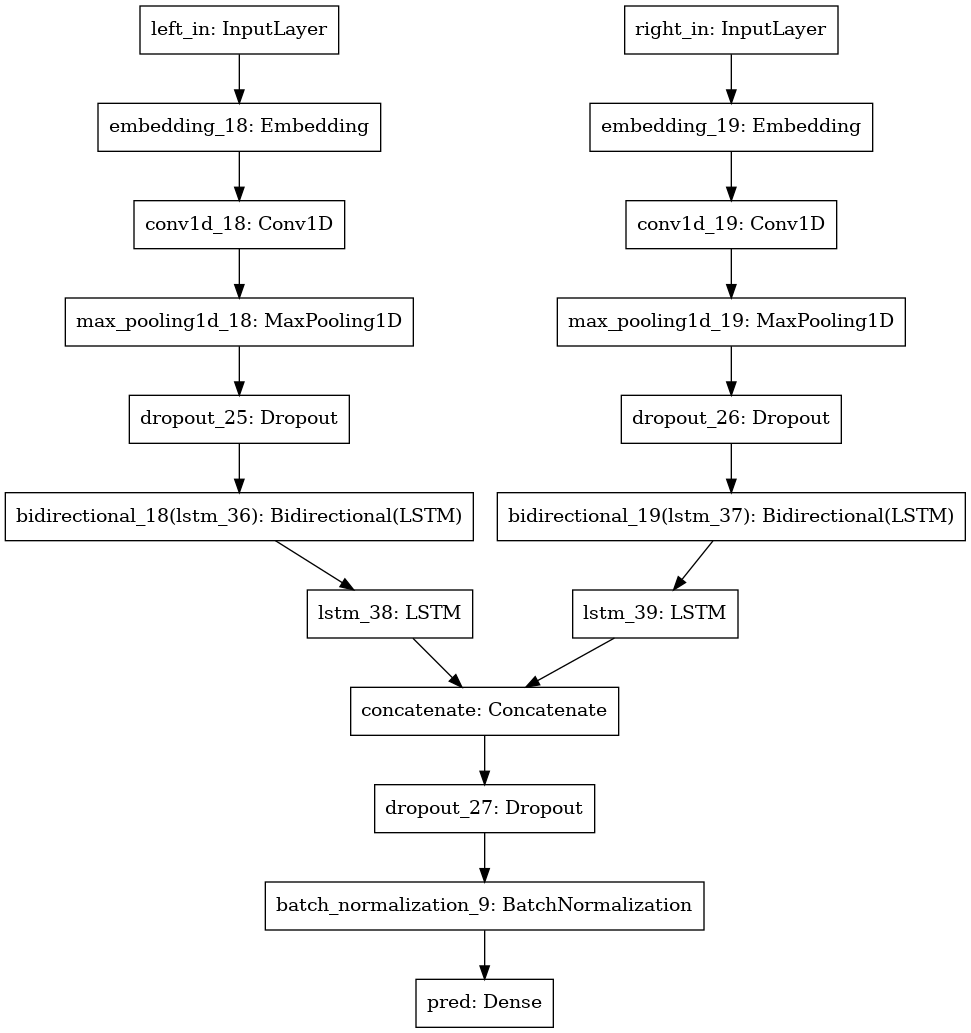

In [ ]:
tensorflow.keras.utils.plot_model(model) 

In [ ]:
# Define callbacks
my_callbacks = [
    EarlyStopping(monitor='accuracy', patience=3)
]

# Train the model
history = model.fit(
    {"left_in": predictors, "right_in": predictors_rev},
    {'pred': label},
    epochs=50,
    batch_size=2048,
    validation_split=0.25,
    #validation_data=([pred_val,predrev_val],label_val),
    callbacks=my_callbacks
)

Epoch 1/50
150/150 [==============================] - 226s 1s/step - loss: 6.7869 - accuracy: 0.1152 - val_loss: 6.7297 - val_accuracy: 0.2580
Epoch 2/50
150/150 [==============================] - 213s 1s/step - loss: 6.3036 - accuracy: 0.1511 - val_loss: 6.4870 - val_accuracy: 0.1757
Epoch 3/50
150/150 [==============================] - 212s 1s/step - loss: 5.7061 - accuracy: 0.2036 - val_loss: 5.8367 - val_accuracy: 0.2258
Epoch 4/50
150/150 [==============================] - 212s 1s/step - loss: 5.2030 - accuracy: 0.2502 - val_loss: 5.0883 - val_accuracy: 0.2817
Epoch 5/50
150/150 [==============================] - 210s 1s/step - loss: 4.8536 - accuracy: 0.2837 - val_loss: 4.4996 - val_accuracy: 0.3352
Epoch 6/50
150/150 [==============================] - 208s 1s/step - loss: 4.5913 - accuracy: 0.3086 - val_loss: 4.2952 - val_accuracy: 0.3440
Epoch 7/50
150/150 [==============================] - 207s 1s/step - loss: 4.3962 - accuracy: 0.3249 - val_loss: 4.2025 - val_accuracy: 0.3477

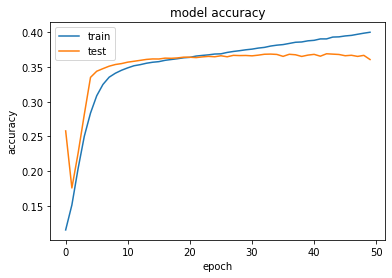

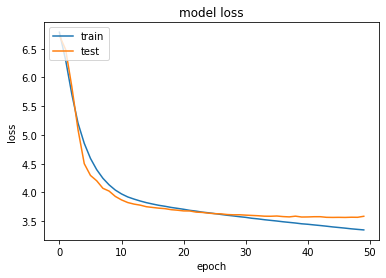

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label = 'Testing Error')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def generate_ngrams(text):    
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]

    all_grams = []

    for n in range(1, len(tokens)+1):
        grams = [w for w in nltk.ngrams(tokens, n=n)][0]
        
        grams_rev = tokens[n:]
        grams_rev.reverse()
        all_grams.append((list(grams), list(grams_rev)))

    return all_grams

In [ ]:
generate_ngrams("सीता खाना माँगता है")

[(['सीता'], ['है', 'माँगता', 'खाना']),
 (['सीता', 'खाना'], ['है', 'माँगता']),
 (['सीता', 'खाना', 'माँगता'], ['है']),
 (['सीता', 'खाना', 'माँगता', 'है'], [])]

In [ ]:
print("Building the Tokenizer...")
data_file = "./text.clean"
data = open(data_file).read()

corpus = data.lower().split("\n")
#print("First sentence in the corpus:", corpus[0])

vocab_size = 1000
max_sequence_len = 15
out_of_vocab = "<unk>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=out_of_vocab)
tokenizer.fit_on_texts(corpus)

Building the Tokenizer...


In [ ]:
texts_to_correct = ["उसेचाय पीनेकी तालाब लगी थ"]
print("Given Sentence : ", texts_to_correct)
for text_to_correct in texts_to_correct:
    
    print("Currently correcting:", text_to_correct)
        
    ngrams = generate_ngrams(text_to_correct)
    correct = None
    suggestions = []
    
    for ngram in ngrams:
            
        if len(ngram[0]) > 2 and correct != 1 and len(suggestions) != 0:
            seed_text_ltr = " ".join(word for word in ngram[0][:-2]) + " " + suggestions[0][2]
        else:
            seed_text_ltr = " ".join(word for word in ngram[0][:-1])
        
        current_word = ngram[0][-1]
        seed_text_rtl = " ".join(word for word in ngram[1])
        print(seed_text_ltr, "->", current_word, "->", seed_text_rtl)

        token_list = tokenizer.texts_to_sequences([seed_text_ltr])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='post')

        token_list_rev = tokenizer.texts_to_sequences([seed_text_rtl])[0]
        token_list_rev = pad_sequences([token_list_rev], maxlen=max_sequence_len-1, padding='post')
        
        predicted_best = np.argsort(-model.predict([token_list, token_list_rev],verbose=0), axis=-1)[0]
        
        suggestions = []
        correct = None

        for prob in predicted_best:
            output_word = tokenizer.sequences_to_texts([[prob]])[0]
            ed = nltk.edit_distance(current_word, output_word)

            if ed ==0:
                correct = 1
                break
            elif len(current_word)<=3 and ed ==1:
                suggestions.append((ed, current_word, output_word))
            elif len(current_word)>3 and ed <=2:
                suggestions.append((ed, current_word, output_word))
            else:
                continue
                    
        if correct != 1 and len(suggestions) > 0:
            print("Suggestions:", " - ".join([suggest[2] for suggest in suggestions]))

        if correct == 1 or len(suggestions) == 0:
            print("CORRECT")
        elif correct != 1 and len(suggestions) > 0:
            correct = 0
            print("WRONG")

        print("-------")

Given Sentence :  ['उसेचाय पीनेकी तालाब लगी थ']
Currently correcting: उसेचाय पीनेकी तालाब लगी थ
 -> उसेचाय -> थ लगी तालाब पीनेकी
CORRECT
-------
उसेचाय -> पीनेकी -> थ लगी तालाब
CORRECT
-------
उसेचाय पीनेकी -> तालाब -> थ लगी
Suggestions: वाला
WRONG
-------
उसेचाय पीनेकी वाला -> लगी -> थ
CORRECT
-------
उसेचाय पीनेकी तालाब लगी -> थ -> 
Suggestions: थे - न - था - थी - आ - व - s
WRONG
-------
